# Domain generation

In [1]:
import timeit

from eminus import Atoms, read_xyz, SCF
from eminus.addons import view_grid
from eminus.domains import domain_cuboid, domain_isovalue, domain_sphere, truncate
from eminus.energies import get_Esic, get_n_single
from eminus.orbitals import KSO

In [2]:
# Start by creating an Atoms object for lithium hydride
# Use a small s to make the resulting grid not too dense to display it
atoms = Atoms(*read_xyz('LiH.xyz'), s=30, center=True)
scf = SCF(atoms)
scf.run();

Start preconditioned conjugate-gradient...
Iteration: 1  	Etot: +4.1108768
Iteration: 2  	Etot: +1.5132949
Iteration: 3  	Etot: +0.6833663
Iteration: 4  	Etot: +0.2959934
Iteration: 5  	Etot: +0.0575298
Iteration: 6  	Etot: -0.1399911
Iteration: 7  	Etot: -0.3596758
Iteration: 8  	Etot: -0.5918944
Iteration: 9  	Etot: -0.7308336
Iteration: 10  	Etot: -0.7669721
Iteration: 11  	Etot: -0.7708643
Iteration: 12  	Etot: -0.7717312
Iteration: 13  	Etot: -0.7718528
Iteration: 14  	Etot: -0.7718725
Iteration: 15  	Etot: -0.7718744
Iteration: 16  	Etot: -0.7718748
Iteration: 17  	Etot: -0.7718749
SCF converged after 17 iterations.
Total SCF time: 0.57576s
Total energy: -0.771874907 Eh


RFBOutputContext()


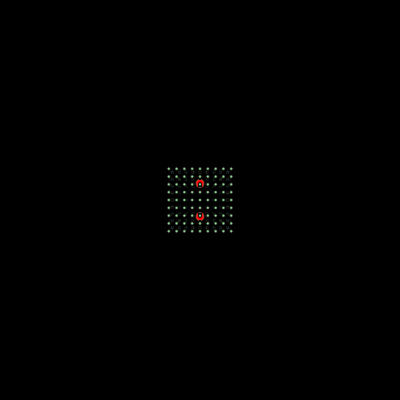

CanvasBackend(css_height='400px', css_width='400px')

In [3]:
# Create a boolean mask for a cuboidal domain
# This will create a domain with side lengths of 3 Bohr,
# with the center in the center at the center of mass of our molecule
mask = domain_cuboid(atoms, 3)

# Display the domain along with the atom positions
# The view_grid function can be used outside of notebooks
view_grid(atoms.r[mask], atoms.X)

RFBOutputContext()


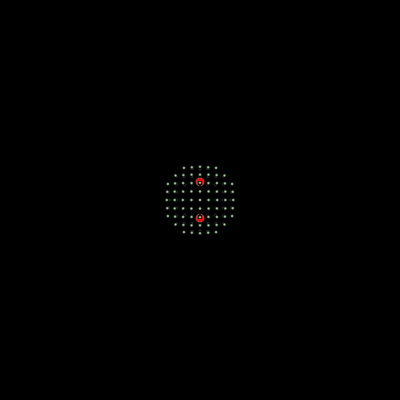

CanvasBackend(css_height='400px', css_width='400px')

In [4]:
# The same can be done for a spherical domain with a radius of 3 Bohr
mask = domain_sphere(atoms, 3)
view_grid(atoms.r[mask], atoms.X)

RFBOutputContext()


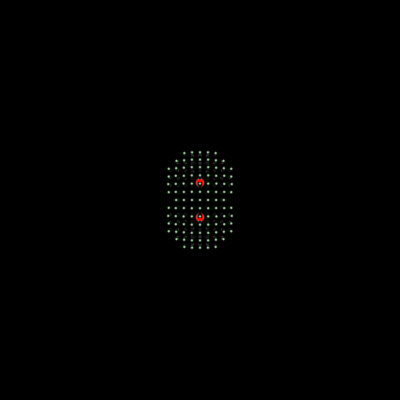

CanvasBackend(css_height='400px', css_width='400px')

In [5]:
# One can also define more than one center
# This will create multiple domains and merge them, here shown with the atom positions as centers
mask = domain_sphere(atoms, 3, atoms.X)
view_grid(atoms.r[mask], atoms.X)

RFBOutputContext()


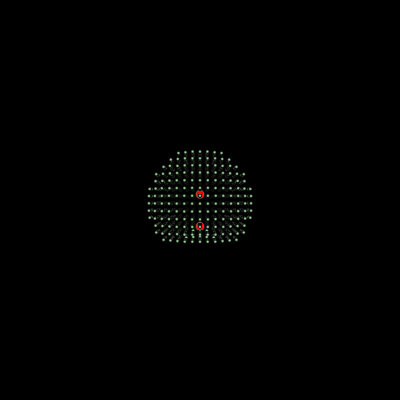

CanvasBackend(css_height='400px', css_width='400px')

In [6]:
# An isovalue can be used to generate a domain from a real-space field data like orbitals
psi = KSO(scf)
mask = domain_isovalue(psi[:, 0], 1e-2)
view_grid(atoms.r[mask], atoms.X)

# The same can be done for the density
# mask = domain_isovalue(atoms.n, 1e-3)
# view_grid(atoms.r[mask], atoms.X)

In [7]:
# Truncated densities can be used to calculate, e.g., SIC energies
# Calculate the single-electron densities from Kohn-Sham orbitals first
ni = get_n_single(atoms, atoms.J(psi))

In [8]:
# Calculate the SIC energy for untruncated densities
start = timeit.default_timer()
esic = get_Esic(scf, scf.W, ni)
end = timeit.default_timer()
print(f'Esic(untruncated) = {esic:.9f} Eh\nTime(untruncated) =  {end - start:.6f} s')

# Calculate the SIC energy for truncated densities
# One can notice a small energy deviation, but a faster calculation time
mask = domain_isovalue(ni, 1e-4)
ni_trunc = truncate(ni, mask)
start = timeit.default_timer()
esic_trunc = get_Esic(scf, scf.W, ni_trunc)
end = timeit.default_timer()
print(f'Esic( truncated ) = {esic_trunc:.9f} Eh\nTime( truncated ) =  {end - start:.6f} s')

Esic(untruncated) = -0.064818923 Eh
Time(untruncated) =  0.006574 s
Esic( truncated ) = -0.064786808 Eh
Time( truncated ) =  0.002664 s


In [9]:
# The truncated SIC energy will converge for smaller isovalues to the untruncated value
mask = domain_isovalue(ni, 0)
ni_trunc = truncate(ni, mask)
esic_trunc = get_Esic(scf, scf.W, ni_trunc)
print(esic == esic_trunc)

True
